# Uncertainty in Deep Learning

In this exercise, we will look at methods to get uncertainties with Neural Networks. We will first try out Bayesian Linear Regression (BLR), followed by DNGO and finally using ensembles of NNs to get uncertainty estimates.

Below is some code to generate 1-D and 2-D data for our experiments.

In [1]:
# some imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

# data generation
def data_1d():
    # generates y data according to the example in Figure 5.1. 
    
    # the data generator; Input: np.array of shape (1)
    def generator(x):
        # data checking
        if isinstance(x, list):
            x = np.array(x)
        if len(x.shape) != 1 or len(x) != 1:
            raise ValueError('x should be a vector of size 1')
        return 1.5 * x[0] + np.random.normal(0.0, 0.1)
    
    # the data
    X_train = np.array([[-0.4], [-0.35], [-0.3], [-0.3], [-0.2], [0.1], [0.2], [0.3], [0.4], [0.6]])
    y_train = np.array([generator(X_train[i]) for i in range(len(X_train))])
    return X_train, y_train


def data_2d(noise_rate = 0.1):
    # generates random data according to the function y = 1.5 * x1 + 0.5 * x2 + epsilon  
    def generator(x):
        # data checking
        if isinstance(x, list):
            x = np.array(x)
        if len(x.shape) != 1 or len(x) != 2:
            raise ValueError('x should be a vector of size 2')
        return 1.5 * x[0] + 0.5 * x[1] + np.random.normal(0.0, noise_rate)

    data_n = 40
    X_train = np.reshape(np.random.random(data_n * 2), (data_n, 2))
    y_train = np.array([generator(X_train[i]) for i in range(len(X_train))])
    return X_train, y_train


In [2]:
fu_train, fu_train_y = data_1d()
fu_train.shape, fu_train_y.shape

((10, 1), (10,))

## Bayesian Linear Regression

Next, we are going to implement Bayesian Linear Regression according to the slides (eqns. 2.4 - 2.9) where we define the prior as having 0 mean and covariance $\Sigma_p$. 

**NOTE: Since the GPML book uses D x n for the X matrix, we will use that formulation for this and ONLY this method in the exercise. That's why ALWAYS call this method with the transpose for the X variable! You are free to implement using n x D notation and change the formulae in the GPML book accordingly.**

Finish the following function which solves eqn. 2.7 from the slides. (3 points)<br>
BONUS: Implement a generalisation of the equation which takes in a non-zero mean as a prior. (2 points)<br> 
WARNING: It could get involved trying to derive the expression.

**The function signature also takes in a mu_pre as a prior mean only for the BONUS part. You don't have to use it in case you don't implement the BONUS part.**

In [3]:
def linreg_bayes(mu_pre, Sigma_pre, X, y, noise):
    
    # START TODO ########################
    # mu_pre is the prior mean, Sigma_pre is the prior covariance,
    # noise is the noise variance sigma_n^2 in the input data
#     prior = np.random.normal(mu_pre, Sigma_pre)
    A = (noise**-2)* np.matmul(X, X.T) + np.linalg.inv(Sigma_pre)
    Sigma_post = np.linalg.inv(A)
    mu_post = (noise**-2)*np.matmul(np.linalg.inv(A), np.matmul(X, y))
    # END TODO ########################
    return mu_post, Sigma_post

We can test whether this works as expected by running the coded Bayesian Linear Regression method on the 1d dataset generated by the data generator above. We will sample from the posterior distribution that we get from the fit of the Bayesian Linear Regression and plot the different linear models corresponding to each sampled weight.

**Note: For simplicity initially, we ignore the bias weights in this part (but not in the NN part later)**

Complete the code below. (3 points)

Avg weight value (sampled from prior) -0.08416551097257124
Avg weight value (sampled from posterior) 0.7394325353782186


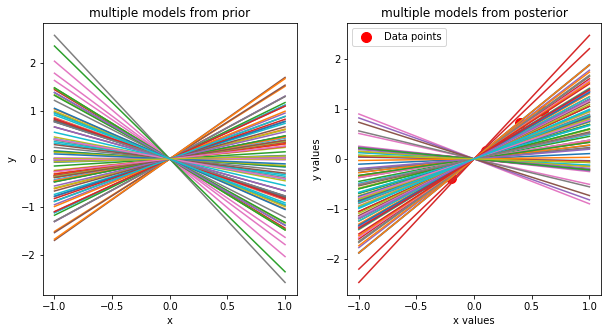

In [5]:
X_train, y_train = data_1d()
Sigma_pre = np.array([[1.0]])
mu_pre = np.array([0.0])
noise = 1.0

# START TODO ########################
# Use the coded BLR method to obtain analytical values for posterior mean and covariance. Be careful about using
# the X_train variable with its transpose when calling linreg_bayes()!
mu_post, Sigma_post = linreg_bayes(mu_pre=mu_pre, Sigma_pre=Sigma_pre, 
                                   X=X_train.T, y=y_train, noise=noise)
# END TODO ########################

# Sample the weights from prior and posterior to generate plots below
distr_prior = scipy.stats.multivariate_normal(mu_pre, Sigma_pre)
distr_post = scipy.stats.multivariate_normal(mu_post, Sigma_post)

# max value at x = mu_post for distr/ post distribution
pdf_max_val = distr_post.pdf(mu_post)

samples = distr_prior.rvs(size=100)
samples_pdf_vals = distr_prior.pdf(samples)

print('Avg weight value (sampled from prior)', samples.mean())
x = np.linspace(-1.0, 1.0, 100)

plt.rcParams['figure.figsize'] = (12.0, 8.0)

# START TODO ########################
# Use the samples from the prior distribution, i.e., the weights from the prior and plot the y values for the
# x values just generated. This will results in multiple linear models being plotted from the prior distribution.
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("multiple models from prior")

for w_prior in samples:
    y_prior_star = w_prior*x
    ax1.plot(x, y_prior_star)
# plt.show()
# END TODO ########################

samples = distr_post.rvs(size=100)
samples_pdf_vals = distr_post.pdf(samples)

print('Avg weight value (sampled from posterior)', samples.mean())

# START TODO ########################
# Now use the samples from the posterior distribution and plot the y values for the
# x values. This will results in multiple linear models being plotted from the posterior distribution.
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("multiple models from posterior")


for w_post in samples:
    y_post_star = w_post*x
    ax2.plot(x, y_post_star)
# plt.show()

# END TODO ########################

plt.scatter(X_train[:,0], y_train, c = 'r', s=100, label='Data points')
plt.legend()
plt.xlabel('x values')
plt.ylabel('y values')
plt.show()

Now perform BLR for the 2-D data generator and generate weight samples. (1 point)

We will plot a contour plot of the pdf of the posterior distribution for the 2 weight dimensions that are fit using BLR. (Plotting code is already filled in)

In [9]:
X_train, y_train = data_2d()
Sigma_pre = np.array([[1.0, 0.0], [0.0, 1.0]])
mu_pre = np.array([1.0, 1.0])


# START TODO ########################
# Similar to the 1-D data preform BLR for the 2-D data. Be careful about using
# the X_train variable with its transpose when calling linreg_bayes()!
mu_post, Sigma_post = linreg_bayes(mu_pre=mu_pre, Sigma_pre=Sigma_pre, 
                                   X=X_train.T, y=y_train, noise=noise)

In [11]:
mu_post, Sigma_post,X_train.shape, y_train.shape

(array([1.31607702, 0.61350321]), array([[ 0.13356157, -0.09630537],
        [-0.09630537,  0.13569104]]), (40, 2), (40,))

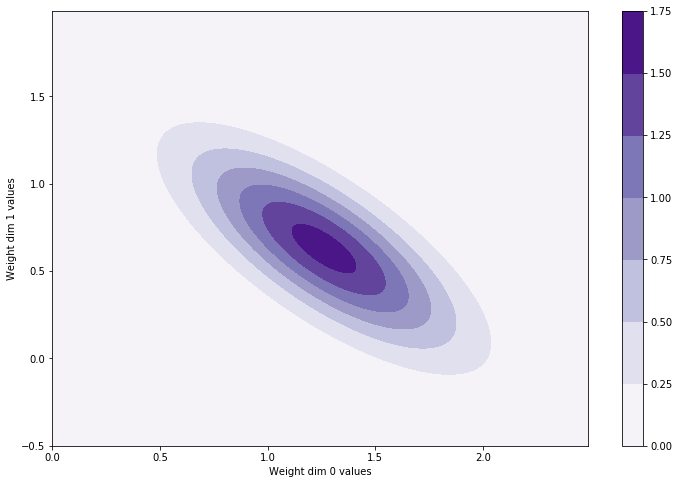

In [12]:
X_train, y_train = data_2d()
Sigma_pre = np.array([[1.0, 0.0], [0.0, 1.0]])
mu_pre = np.array([1.0, 1.0])


# START TODO ########################
# Similar to the 1-D data preform BLR for the 2-D data. Be careful about using
# the X_train variable with its transpose when calling linreg_bayes()!
mu_post, Sigma_post = linreg_bayes(mu_pre=mu_pre, Sigma_pre=Sigma_pre, 
                                   X=X_train.T, y=y_train, noise=noise)
distr_prior = scipy.stats.multivariate_normal(mu_pre, Sigma_pre)
distr_post = scipy.stats.multivariate_normal(mu_post, Sigma_post)

# END TODO ########################

delta = 0.01
x, y = np.mgrid[0:2.5:delta, -0.5:2:delta]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y
# plt.contourf(x, y, distr_prior.pdf(pos), cmap='Purples')
plt.contourf(x, y, distr_post.pdf(pos), cmap='Purples')
plt.xlabel('Weight dim 0 values')
plt.ylabel('Weight dim 1 values')
plt.colorbar()
plt.show()


## Uncertainties using DNGO

As stated in the lecture, DNGO first trains an NN to completion and then takes the learnt features from the last hidden layer and performs BLR on it.

The first 2 cells contain utility code for mini-batching data, evaluating loss and a training loop for evaluating NN models.

In [15]:
# Some initial setup: Importing required libraries
import os
from typing import Tuple, List, Iterable

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
torch.manual_seed(0)

def minibatched(data: np.ndarray, batch_size: int) -> List[np.ndarray]:
    """Mini-batchifies data"""
    assert len(data) % batch_size == 0, ("Data length {} is not multiple of batch size {}"
                                         .format(len(data), batch_size))
    return data.reshape(-1, batch_size, *data.shape[1:])

def evaluate_loss(model: nn.Module, loss_func: nn.Module, 
                  x: torch.Tensor, y: torch.Tensor) -> Tuple[float, float]:
    """Evaluates given loss function for given data for the given model"""
    model.eval()
    correct = 0
    loss = []
    with torch.no_grad():
        output = model(x)
        loss = loss_func(output, y)
    return loss.numpy()

In [16]:
def evaluate_model(model, optimizer, loss_func, scheduler, x_train, y_train, x_test, y_test, epochs, batch_size):
    print("Training and evaluating model...")

    train_losses = []
    test_losses = []

    for epoch in range(int(epochs)):
        print("  Epoch {} / {} ...".format(epoch + 1, epochs).ljust(2))
        loss = 0
        train_loss = 0
        model.train()

        ix = np.arange(len(x_train))
        np.random.shuffle(ix)
        
        shuffled_data = zip(minibatched(x_train[ix], batch_size), minibatched(y_train[ix], batch_size))

        for i, (x, y) in enumerate(shuffled_data):
            optimizer.zero_grad()
            output = model(x)
            loss = loss_func(output, y)
            loss.backward()
            optimizer.step()
        train_loss = evaluate_loss(model, loss_func, x_train, y_train)
        test_loss = evaluate_loss(model, loss_func, x_test, y_test)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print('Train loss:', train_losses[-1], 'Test loss:', test_losses[-1])
        scheduler.step()

    return train_losses, test_losses


Complete the code for the DNGO class below (3 points)

**We won't ignore the bias anymore and take it into account**

In [17]:
class DNGO(nn.Sequential):
    """"""
    def __init__(self, *args, **kwargs):
        """Init for the class"""
        super(DNGO, self).__init__(*args, **kwargs)
        self.last_hidden_layer_saved = False
    
    def last_hidden_layer_features(self, x):
        """"""
        if not self.last_hidden_layer_saved:
            self.last_hidden_layer = nn.Sequential(*list(self.children())[:-1])
            self.last_hidden_layer_saved = True
        return self.last_hidden_layer(x).detach().numpy()
    
    def fit_blr_model(self, mu_pre, Sigma_pre, x_train, y_train, noise):
        """"""
        # START TODO ########################
        # Use last_hidden_layer_features() above to generate the learnt features
        # from the last hidden layer of the NN and then perform BLR to get the posterior distribution
        # for weights (using the same method as used above 
        # for the 1-D and 2-D linear cases). Store these as variables of the class so they can be
        # reused later. Be careful about calling the x_train variable with its transpose when 
        # calling linreg_bayes()!
        # gives a numpy array of last hidden layer features.
        feat_last_hidden = self.last_hidden_layer_features(x_train)
        col_bias = np.ones((feat_last_hidden.shape[0], 1))
        feat_last_hidden = np.hstack((feat_last_hidden, col_bias))
        
        self.mu_post, self.Sigma_post = linreg_bayes(mu_pre=mu_pre, Sigma_pre=Sigma_pre, 
                                   X=feat_last_hidden.T, y=y_train, noise=noise)
        print(f'mu_post shape: {self.mu_post.shape}, Sigma_post shape: {self.Sigma_post.shape}')
        # Sample the weights from prior and posterior to generate plots below
        # END TODO ########################

    def set_last_hidden_layer_weights(self):
        # Utility function
        last_hidden_layer_weights = self.state_dict()['4.weight'].T.detach().numpy()
        bias = self.state_dict()['4.bias'].detach().numpy()

        self.last_hidden_layer_weights = np.vstack([last_hidden_layer_weights, bias]) # for bias
        
    def predict_mean_and_std(self, x):
        """"""
        # START TODO ########################
        # Predict the mean prediction of DNGO using eqn. 2.9. Note that you only have to multiply 
        # the mean estimate from eqn 2.7 (which were saved for the class in fit_blr_model()) 
        # with each of the points in x to get the mean estimate and pre- and post-multiply the covariance
        # estimate with x^T and x to get the std. dev. at each of the points in x.
        # basis function from hidden layer
        feat_last_hidden = self.last_hidden_layer_features(x)
        col_bias = np.ones((feat_last_hidden.shape[0], 1))
        feat_last_hidden = np.hstack((feat_last_hidden, col_bias))
        
        self.mean = np.matmul(feat_last_hidden, self.mu_post)
        self.std_dev = np.matmul(np.matmul(feat_last_hidden,self.Sigma_post), feat_last_hidden.T)
        return self.mean, self.std_dev
        # END TODO ########################
        

We will fit a rescaled version of the sinc function. We plot it here.

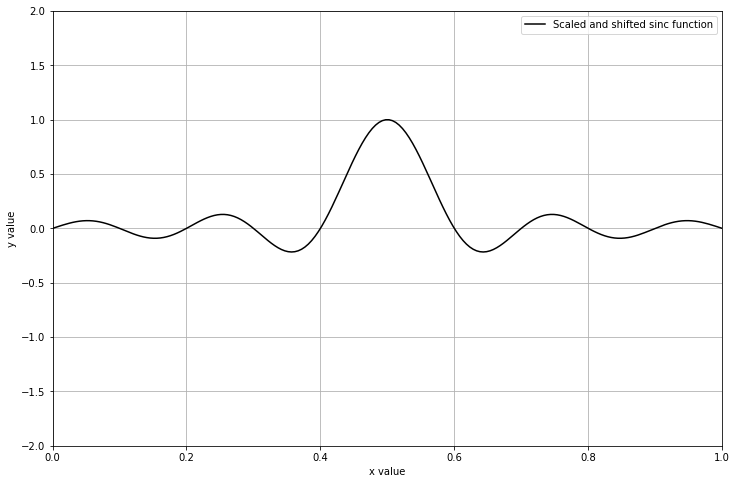

In [18]:
grid = np.linspace(0, 1, 200)
fvals = np.sinc(grid * 10 - 5)

plt.rcParams['figure.figsize'] = (12.0, 8.0)

plt.plot(grid, fvals, "k", label='Scaled and shifted sinc function')
plt.grid()
plt.xlim(0, 1)
plt.ylim(-2, 2)

plt.legend(loc='best')
plt.xlabel('x value')
plt.ylabel('y value')

plt.show()

Now we will train the base NN for DNGO. The training loop is implemented for you below. You can play around with the hyperparameters if you want. But uncertainty methods in NNs are usually sensitive to the hyperparameters and the ones below usually work. The plotting is also already coded in the next cell. Train to an MSE loss of less than 1e-2 and then the plots should look good.

In [19]:
n_train = 30
np.random.seed(42)
x_train = np.random.uniform(0, 1, n_train)
y_train = np.sinc(x_train * 10 - 5)

x_train = torch.FloatTensor(x_train[:, None])
y_train = torch.FloatTensor(y_train[:, None])

x_test = np.random.uniform(0, 1, 20)
y_test = np.sinc(x_test * 10 - 5)
x_test = torch.from_numpy(x_test[:, None]).float()
y_test = torch.from_numpy(y_test[:, None]).float()

# The initialization of the weights turns out to be crucial for good training with the given hyperparameters,
# so we do that here.
def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.normal_(module.weight, mean=0, std=2)
        nn.init.constant_(module.bias, val=0.0)

        
dngo_model = DNGO(
  nn.Linear(in_features=1, out_features=50, bias=True),
  nn.Tanh(),
  nn.Linear(in_features=50, out_features=50, bias=True),
  nn.Tanh(),
  nn.Linear(in_features=50, out_features=1, bias=True),
).apply(init_weights)

# epochs = 10000
epochs = 100
batch_size=n_train//2
lr = 1e-2

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(dngo_model.parameters(), lr=lr)
lambda1 = lambda epoch: 1.
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

train_losses, test_losses = evaluate_model(model=dngo_model, optimizer=optimizer, loss_func=criterion,
                scheduler=scheduler, x_train=x_train, y_train=y_train, x_test=x_test,
                   y_test=y_test, epochs=epochs, batch_size=batch_size)


Training and evaluating model...
  Epoch 1 / 100 ...
Train loss: 50.032696 Test loss: 49.760254
  Epoch 2 / 100 ...
Train loss: 128.00645 Test loss: 134.24184
  Epoch 3 / 100 ...
Train loss: 88.48297 Test loss: 84.44888
  Epoch 4 / 100 ...
Train loss: 6.4140754 Test loss: 6.2049546
  Epoch 5 / 100 ...
Train loss: 0.4151192 Test loss: 0.91809547
  Epoch 6 / 100 ...
Train loss: 0.14952426 Test loss: 0.33048457
  Epoch 7 / 100 ...
Train loss: 0.110411115 Test loss: 0.15170139
  Epoch 8 / 100 ...
Train loss: 0.08958019 Test loss: 0.1720326
  Epoch 9 / 100 ...
Train loss: 0.1036447 Test loss: 0.2020568
  Epoch 10 / 100 ...
Train loss: 0.08548048 Test loss: 0.15618467
  Epoch 11 / 100 ...
Train loss: 0.07453874 Test loss: 0.14894652
  Epoch 12 / 100 ...
Train loss: 0.089546494 Test loss: 0.17883907
  Epoch 13 / 100 ...
Train loss: 0.08284929 Test loss: 0.14943036
  Epoch 14 / 100 ...
Train loss: 0.07287565 Test loss: 0.14250939
  Epoch 15 / 100 ...
Train loss: 0.07184545 Test loss: 0.1463630

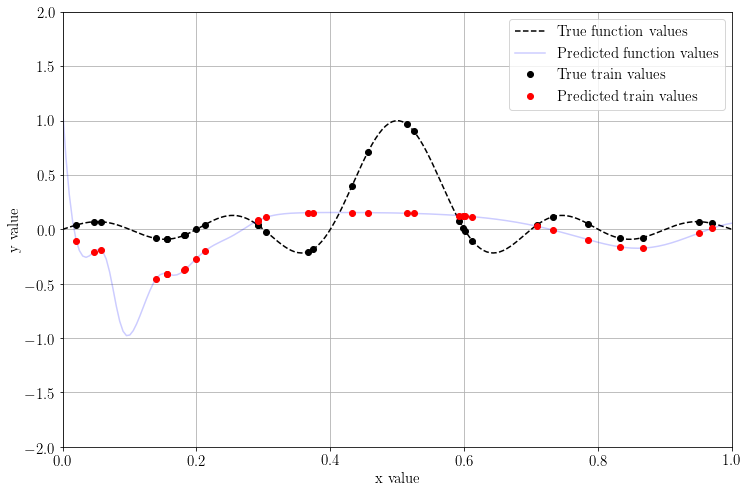

In [21]:
xlim = (-0, 1)
ylim = (-2, 2)
grid = np.linspace(*xlim, 200)
fvals = np.sinc(grid * 10 - 5)

def plot_predictions(model):
    grid_preds = model(torch.from_numpy(grid[:, None]).float()).detach().numpy()
    pred_y = model(x_train.float()).detach().numpy()

    plt.rc('text', usetex=True)
    plt.rc('font', size=15.0, family='serif')
    plt.rcParams['figure.figsize'] = (12.0, 8.0)
#     plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]

    plt.plot(grid, fvals, "k--", label='True function values')

    plt.plot(grid, grid_preds[:, 0], "b", alpha=0.2, label='Predicted function values')

    plt.plot(x_train.numpy(), y_train.numpy(), "ko", label='True train values')
    plt.plot(x_train.numpy(), pred_y, "ro", label='Predicted train values')
    plt.grid()
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.legend(loc='best')
    plt.xlabel('x value')
    plt.ylabel('y value')

    plt.show()
    
plot_predictions(dngo_model)

Write the code to plot uncertainties of trained models. (2 points)

In [22]:
xlim = (-0, 1)
ylim = (-2, 2)
grid_plot = np.linspace(*xlim, 20)
grid = torch.from_numpy(grid_plot).float()
grid_fu = torch.from_numpy(grid_plot[:, None]).float()

In [23]:
grid.shape, grid_fu.shape

(torch.Size([20]), torch.Size([20, 1]))

In [25]:
def plot_uncertainty(model):  
    # START TODO ########################
    # Use the predict_mean_and_std() function of the DNGO model to get mean predictions
    # and standard deviations to plot uncertainties, i.e., on a grid of values (e.g. the one defined previously) 
    # plot the true function values and the predicted function values with an uncertainty band
    # around the predicted values. For plotting the uncertainy band, you can use
    # fill_between() from matplotlib to plot a band which is +- std. dev thick
    # around the predicted values with some transparency value
    xlim = (-0, 1)
    ylim = (-2, 2)
    grid_plot = np.linspace(*xlim, 200)
    grid = torch.from_numpy(grid_plot[:, None]).float()
    fvals = np.sinc(grid * 10 - 5)
    mean, std_dev = model.predict_mean_and_std(grid)
    mean_variation = np.diag(std_dev)
    
    print(f'mean shape: {mean.shape}')
    # check the size of mean, std_dev
    assert mean.shape == (grid.shape[0], 1), "incorrect size for mean"
    assert std_dev.shape == (grid.shape[0], grid.shape[0]), "incorrect size for std_dev"
    
    upper_limit = mean.detach().numpy() + mean_variation.reshape(np.shape(mean))
    upper_limit = upper_limit.reshape(np.shape(grid_plot))
    lower_limit = mean.detach().numpy() - mean_variation.reshape(np.shape(mean))
    lower_limit = lower_limit.reshape(np.shape(grid_plot))

    # END TODO ########################
    fig, ax = plt.subplots(1)
    ax.fill_between(grid_plot, lower_limit,  upper_limit)
    
    ax.set_xlabel('x value')
    ax.set_ylabel('y value')
    ax.set_title('best model')

    plt.show()



mu_post shape: torch.Size([51, 1]), Sigma_post shape: (51, 51)
mean shape: torch.Size([200, 1])


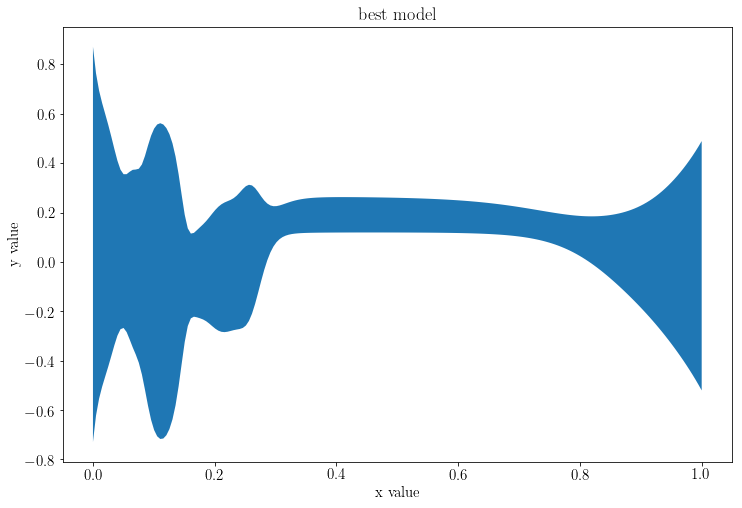

In [26]:
Sigma_pre = np.identity(50 + 1) # 50 features in last hidden layer + 1 for bias
mu_pre = np.zeros((50 + 1, 1))
noise = 1.0

dngo_model.fit_blr_model(mu_pre, Sigma_pre, x_train, y_train, noise)
plot_uncertainty(dngo_model)

# # ONLY for the BONUS part above:
# dngo_model.set_last_hidden_layer_weights()
# mu_pre = dngo_model.last_hidden_layer_weights
# dngo_model.fit_blr_model(mu_pre, Sigma_pre, x_train, y_train, noise)
# plot_uncertainty(dngo_model)


## Uncertainties using Ensembles

We will now train an ensemble of NNs and get the mean prediction as the mean over the predictions of the individual NNs and the std. dev. as the std. dev. over the predictions. We will define a class which holds a list of base NNs and implement the predict_mean_and_std() function for it.

Complete the code for an ensemble of NNs below. (2 points)

In [27]:
class EnsembleSequential():
    """Holds an ensemble of NNs which are used to get prediction means and uncertainties."""
    def __init__(self, *args, num_models=5, ensembled_nets, **kwargs):
        """Init for the class"""
        super(EnsembleSequential, self).__init__(*args, **kwargs)
        self.num_models = num_models
        self.ensembled_nets = ensembled_nets
    
    def predict_mean_and_std(self, x, 
                             return_individual_predictions: bool = False) -> Tuple[torch.Tensor, torch.Tensor]:
        """Returns mean and standard deviation of the predictions of the ensembled networks
        
        In case return_individual_predictions is True, return all the predictions of the ensembled networks, 
        as a Torch tensor
        """
        # START TODO ########################
        # Iterate over the list of base NNs held by the ensemble and collect the predictions for each
        # NN. Then take the mean and std. dev. over the predictions and return them.
        # If return_individual_predictions = True, then instead of returning the mean and std. dev.,
        # return the individual predictions of the NNs.
        
        if (return_individual_predictions == False):
            # return mean and std. dev of ensemble
            var = np.zeros((np.shape(x)[0], np.shape(x)[0]))
            predictions = np.empty((np.shape(x)[0], 0), float)
            # loop for calculating mean
            for i_mod in range(self.num_models):
                model = self.ensembled_nets[i_mod]
                model_pred = model(x)
                # detach and append to predictions matrix
                predictions=np.append(predictions, model_pred.detach().numpy(), axis=1)
            
            assert predictions.shape == (x.shape[0], self.num_models), "incorrect dimensions for predictions"
                
            mean = np.mean(predictions, axis=1).reshape(x.shape[0], 1)
            mean_tensor = torch.from_numpy(mean).float()
            
            # loop for calculating std dev
            for i_mod in range(self.num_models):
                model = self.ensembled_nets[i_mod]
                model_pred = model(x)
                # detach and append to predictions matrix
                out_np = model_pred.detach().numpy()
                var = var + np.matmul((out_np - mean), (out_np - mean).T)
            std = np.sqrt(1/self.num_models * var)
            print(f'mean shape:{mean.shape}, std shape:{std.shape}')
                
        else:
            predictions = np.empty((np.shape(x)[0], 0), float)
            # loop for calculating mean
            for i_mod in range(self.num_models):
                model = self.ensembled_nets[i_mod]
                model_pred = model(x)
                # detach and append to predictions matrix
                predictions=np.append(predictions, model_pred.detach().numpy(), axis=1)
            
            assert predictions.shape == (x.shape[0], self.num_models), "incorrect dimensions for predictions"
            return predictions
        # END TODO ########################
        return mean_tensor, std

ensembled_nets = []
num_models=5


# The initialization of the weights turns out to be crucial for getting good uncertainty estimates,
# so we do that here.
def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.normal_(module.weight, mean=0, std=2)
        nn.init.constant_(module.bias, val=0.0)


for i in np.arange(num_models):
    temp_model = nn.Sequential(
      nn.Linear(in_features=1, out_features=50, bias=True),
      nn.Tanh(),
      nn.Linear(in_features=50, out_features=50, bias=True),
      nn.Tanh(),
      nn.Linear(in_features=50, out_features=1, bias=True),
    ).apply(init_weights)
    ensembled_nets.append(temp_model)

ensemble = EnsembleSequential(ensembled_nets=ensembled_nets)

for i in np.arange(num_models):
    criterion = torch.nn.MSELoss()
    epochs=10000
    epochs=100
    lr = 1e-2
    optimizer = torch.optim.SGD(ensemble.ensembled_nets[i].parameters(), lr=lr)
    lambda1 = lambda epoch: 1.
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

    print('Training for model', i, 'in the ensemble')
    train_losses, test_losses = evaluate_model(model=ensemble.ensembled_nets[i], optimizer=optimizer, loss_func=criterion,
                    scheduler=scheduler, x_train=x_train, y_train=y_train, x_test=x_test,
                       y_test=y_test, epochs=epochs, batch_size=batch_size)
    

Training for model 0 in the ensemble
Training and evaluating model...
  Epoch 1 / 100 ...
Train loss: 82.24845 Test loss: 98.75579
  Epoch 2 / 100 ...
Train loss: 7.771369 Test loss: 7.005499
  Epoch 3 / 100 ...
Train loss: 3.158639 Test loss: 2.8374386
  Epoch 4 / 100 ...
Train loss: 0.4476987 Test loss: 0.40589833
  Epoch 5 / 100 ...
Train loss: 0.2518962 Test loss: 0.27324903
  Epoch 6 / 100 ...
Train loss: 0.17749308 Test loss: 0.22797123
  Epoch 7 / 100 ...
Train loss: 0.14146526 Test loss: 0.1800574
  Epoch 8 / 100 ...
Train loss: 0.121526726 Test loss: 0.15125594
  Epoch 9 / 100 ...
Train loss: 0.104231745 Test loss: 0.14372534
  Epoch 10 / 100 ...
Train loss: 0.096364416 Test loss: 0.15174825
  Epoch 11 / 100 ...
Train loss: 0.08380231 Test loss: 0.13343073
  Epoch 12 / 100 ...
Train loss: 0.08965859 Test loss: 0.14601919
  Epoch 13 / 100 ...
Train loss: 0.08440553 Test loss: 0.12049433
  Epoch 14 / 100 ...
Train loss: 0.09748656 Test loss: 0.15535638
  Epoch 15 / 100 ...
Train

Train loss: 0.08315835 Test loss: 0.14160776
  Epoch 28 / 100 ...
Train loss: 0.08231991 Test loss: 0.14178711
  Epoch 29 / 100 ...
Train loss: 0.087764695 Test loss: 0.13749728
  Epoch 30 / 100 ...
Train loss: 0.088107996 Test loss: 0.17029983
  Epoch 31 / 100 ...
Train loss: 0.09344829 Test loss: 0.1718694
  Epoch 32 / 100 ...
Train loss: 0.087248154 Test loss: 0.13768499
  Epoch 33 / 100 ...
Train loss: 0.07835545 Test loss: 0.14002134
  Epoch 34 / 100 ...
Train loss: 0.07904006 Test loss: 0.135011
  Epoch 35 / 100 ...
Train loss: 0.077271774 Test loss: 0.13654493
  Epoch 36 / 100 ...
Train loss: 0.07785266 Test loss: 0.14376643
  Epoch 37 / 100 ...
Train loss: 0.077100836 Test loss: 0.13935447
  Epoch 38 / 100 ...
Train loss: 0.08427944 Test loss: 0.15750876
  Epoch 39 / 100 ...
Train loss: 0.07851176 Test loss: 0.14508434
  Epoch 40 / 100 ...
Train loss: 0.077904314 Test loss: 0.14468929
  Epoch 41 / 100 ...
Train loss: 0.07557297 Test loss: 0.13790345
  Epoch 42 / 100 ...
Train l

Train loss: 0.039146613 Test loss: 0.07131396
  Epoch 59 / 100 ...
Train loss: 0.04051156 Test loss: 0.07239211
  Epoch 60 / 100 ...
Train loss: 0.03768736 Test loss: 0.06856065
  Epoch 61 / 100 ...
Train loss: 0.038795907 Test loss: 0.069413215
  Epoch 62 / 100 ...
Train loss: 0.042612385 Test loss: 0.07041558
  Epoch 63 / 100 ...
Train loss: 0.039786506 Test loss: 0.06674506
  Epoch 64 / 100 ...
Train loss: 0.03475455 Test loss: 0.06390589
  Epoch 65 / 100 ...
Train loss: 0.035681702 Test loss: 0.0624048
  Epoch 66 / 100 ...
Train loss: 0.037941802 Test loss: 0.06503004
  Epoch 67 / 100 ...
Train loss: 0.032726094 Test loss: 0.059406612
  Epoch 68 / 100 ...
Train loss: 0.03353679 Test loss: 0.058802497
  Epoch 69 / 100 ...
Train loss: 0.031322327 Test loss: 0.057452954
  Epoch 70 / 100 ...
Train loss: 0.033502687 Test loss: 0.058496807
  Epoch 71 / 100 ...
Train loss: 0.033699192 Test loss: 0.055651467
  Epoch 72 / 100 ...
Train loss: 0.028344579 Test loss: 0.052401353
  Epoch 73 / 1

Train loss: 0.009708621 Test loss: 0.020489482
  Epoch 86 / 100 ...
Train loss: 0.011799176 Test loss: 0.026928354
  Epoch 87 / 100 ...
Train loss: 0.013953772 Test loss: 0.028506786
  Epoch 88 / 100 ...
Train loss: 0.0117792655 Test loss: 0.019947316
  Epoch 89 / 100 ...
Train loss: 0.009631509 Test loss: 0.022910317
  Epoch 90 / 100 ...
Train loss: 0.010489201 Test loss: 0.020412726
  Epoch 91 / 100 ...
Train loss: 0.008643648 Test loss: 0.019992126
  Epoch 92 / 100 ...
Train loss: 0.008179229 Test loss: 0.02307758
  Epoch 93 / 100 ...
Train loss: 0.011040938 Test loss: 0.024967242
  Epoch 94 / 100 ...
Train loss: 0.01315639 Test loss: 0.031446684
  Epoch 95 / 100 ...
Train loss: 0.011511945 Test loss: 0.023277178
  Epoch 96 / 100 ...
Train loss: 0.013166388 Test loss: 0.026871424
  Epoch 97 / 100 ...
Train loss: 0.014811123 Test loss: 0.02712265
  Epoch 98 / 100 ...
Train loss: 0.018075235 Test loss: 0.035091516
  Epoch 99 / 100 ...
Train loss: 0.0075044744 Test loss: 0.02157979
  E

Complete the plotting code below to plot individual predictions of the members of the ensemble. (2 points)

In [28]:
def plot_multiple_predictions(model):
    # START TODO ########################
    # Use the predict_mean_and_std() function of the ensemble with return_individual_predictions = True
    # to get individual predictions (over a grid as before) for each of the members of the ensemble.
    # Plot all of these one by one using plot() with some transparency using its alpha parameter
    # so that you get a good visualization of the individual predictions
    xlim = (-0, 1)
    ylim = (-2, 2)
    grid_plot = np.linspace(*xlim, 200)
    grid_plot = torch.from_numpy(grid_plot[:, None]).float()
    
    plt.grid()
    
    # plot individual predictions
    predictions = model.predict_mean_and_std(grid_plot, return_individual_predictions = True)
    
    print(f'predictions: {predictions.shape}')
    # alpha values for transparency
    alphas = np.linspace(start=0.2, stop=1, num=5)
    colors = ['r', 'b', 'g', 'k', 'c']
    for i in range(model.num_models):
        y_plot = predictions[:, i]
        plt.plot(grid_plot, y_plot, c=colors[i], alpha=alphas[i])

    # END TODO ########################
    plt.legend(loc='best')
    plt.xlabel('x value')
    plt.ylabel('y value')

    plt.show()
    


No handles with labels found to put in legend.


predictions: (200, 5)


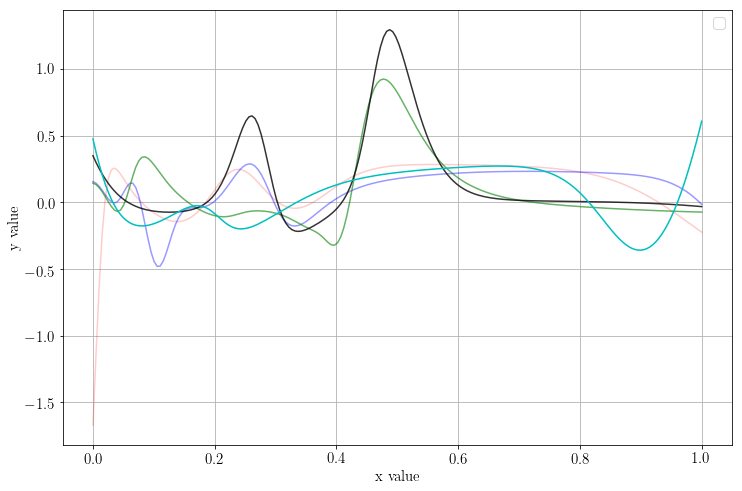

In [29]:
plot_multiple_predictions(ensemble)

/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt


mean shape:(200, 1), std shape:(200, 200)
mean shape: torch.Size([200, 1])


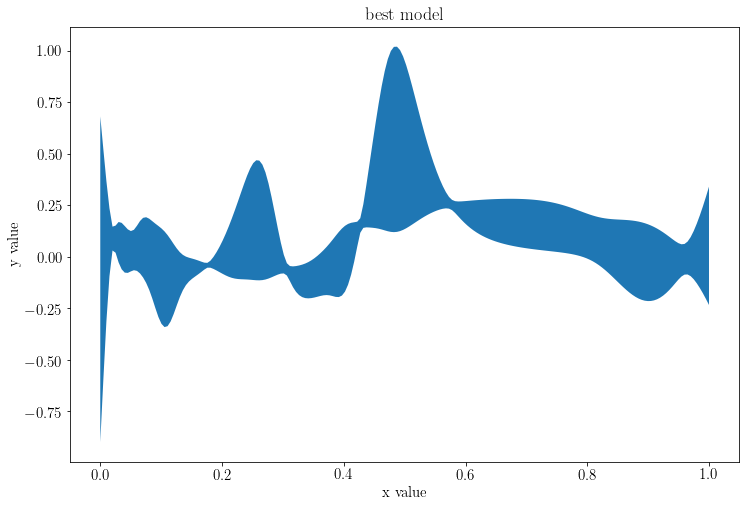

In [30]:
plot_uncertainty(ensemble)